In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines import*
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter  #cox-proportional hazard ratio
import matplotlib.pyplot as plt
kmf=KaplanMeierFitter()
cph=CoxPHFitter()

In [198]:
# Data cleaning time
time = pd.read_excel(r"C:\Data\Cox\Template for Suvival analysis all LNs.xlsx", header=None)
time2 = time.replace({0:{24167:"01-24167B17","7P":"03292019_RZ_DC PD-L1 Panel_14346-1-7 SLN(N)x9",
                                "hc-04":"12195-01-04x1","hc-08":"12195-01-08",
                                "hc-18":"12195-01-18x1","hc-22":"12195-01-22x1", "hc-24":"12195-01-24x1",
                                "hc-27":"12195-01-27x1","hc-29":"12195-01-29","hc-35":"12195-01-35x1","hc-43":"12195-01-43x1",
                                "hc-44":"12195-01-45x1","hc-47":"12195-01-47x1","hc-50":"12195-01-50x1",
                                "VPt3":"12195-03-LNNA1x4","VPt12":"12195-12-LNNa1x4","VPt15":"12195-15-LNNA1x7",
                                "VPT17":"12195-17-LNNA1x3","VPt19":"12195-19-LNNA1x7","VPt20":"12195-20-LNNA1x4",
                                "VPt21":"12195-21-LNNA1x7","VPt22":"12195-22-LNNA1x4","VPt26":"12195-26-LNNA1x8",
                                "VPt28":"12195-28-LNNA1x7","VPt29":"12195-29-LNNB1x7","VPt31":"12195-31-LNNA1x4",
                                "Pt10":"14346-1-10-LNx5","Pt13":"14346-1-13-SNL(N)x6", "Pt14":"14346-1-14-LN(N)x8",
                                "Pt16":"14346-1-16-LN(N)x6","Pt2":"14346-1-2-LN-Nx5",21:"14346-1-21 Cx6","Pt22":"14346-1-22-B2x1",
                                "Pt25":"14346-1-25-A1x1","Pt26":"14346-1-26-E1x4","Pt29":"14346-1-29-E21x2",
                                "Pt30":"14346-1-30 B1x5","5P":"14346-1-5-LN(N)x10","9P":"14346-1-9-SLN(N)x11",
                        "8403G":"8403Gx2", 23:"20190222_RZ_DC PD-L1 Panel_14346-1-23 (Block #A2)x4",
                        28:"20190222_RZ_DC PD-L1 Panel_14346-1-28 (Block #B1)x6","Pt37":"20190222_RZ_DC PD-L1 Panel_14346-1-37 C1x3",
                        "Pt36":"14346-1-36-C1x2",33:"14346-1-33 A1x9",38:"14346-1-38 A1x9",39:"14346-1-39 A1x6",
                        "VPt9":"20190222_RZ_DC PD-L1 Panel_12195-09 LNNA1x5","VPt13":"20190222_RZ_DC PD-L1 Panel_12195-13 LNNA1x5",
                        "VPt23":"20190222_RZ_DC PD-L1 Panel_12195-23 LNNC2x6","Pt32":"14346-1-32 Ax1"}})
time3 = time2.rename(columns={0:"Pt",1:"Days",2:"ifRelapse"}).drop(columns=3)

# Data: proportion of DCs found in homo and heterocluster 
data = pd.read_csv(r"C:\Data\DCs_results\DCs_dedicated_to_Cluster_TotDCs.txt")
data2 = data[["Pt","CD1a+_%h","CD1a+_%het","cDC1_%h","cDC1_%het"]]
# Merge data with Size of clusters
df = pd.merge(time3, data2, on=["Pt"], how="inner")
data_clustersize = pd.read_csv(r"C:\Data\DCs_results\SIZE_cType_Pts.txt")
data_clustersize["Pt"] = data_clustersize["Unnamed: 0"]
data_clustersize = data_clustersize.drop(columns="Unnamed: 0")
df2 = pd.merge(df, data_clustersize, on=["Pt"], how="inner").fillna(0)

# DataNew: porportion of PD-L1+DCs (out of all DCs in slide)-cDC1
df_Cluster_pv2 = pd.read_csv("C:/Data/DCs_results/c_Type.txt")
df_Cluster_pv2_Pt = df_Cluster_pv2[~df_Cluster_pv2["Pt"].isin(["Norm LN1x4","Norm LN2x4","Norm LN3x4","Norm LN4x4"])].drop(columns=["Unnamed: 0"])
df_Cluster_pv2_PtHet = df_Cluster_pv2_Pt[(df_Cluster_pv2_Pt.c_Type=="Het")][["Pt","CD141+PD-L1+"]].pivot_table(index=["Pt"],aggfunc=lambda x:sum(x))
New_merge = pd.merge(df_Cluster_pv2_PtHet, data, on=["Pt"])
New_merge["%PD-L1HetcDC1 out all cDC1"] = 100*New_merge["CD141+PD-L1+"]/New_merge["cDC1_ct"].round(1)
New_data=New_merge[["Pt","%PD-L1HetcDC1 out all cDC1"]].round(1)
df3 = pd.merge(df2, New_data, on=["Pt"], how="inner")

# DataNew: porportion of PD-L1+DCs (out of all DCs in slide)-CD1A
df_Cluster_pv2_PtHet1A_PDL1 = df_Cluster_pv2_Pt[(df_Cluster_pv2_Pt.c_Type=="Het")][["Pt","CD1a+PD-L1+"]].pivot_table(index=["Pt"],aggfunc=lambda x:sum(x))
df_Cluster_pv2_Pt["Total CD1a+"] = df_Cluster_pv2_Pt["CD1a+PD-L1+"]+df_Cluster_pv2_Pt["CD1a+PD-L1-"]
partial1AdATA = df_Cluster_pv2_Pt[["Pt","Total CD1a+"]].pivot_table(index=["Pt"],aggfunc = lambda x:sum(x))
partial1AdATA=partial1AdATA[(partial1AdATA["Total CD1a+"]!=0)]
New_data_1A = pd.merge(df_Cluster_pv2_PtHet1A_PDL1,partial1AdATA, on=["Pt"], how="inner")
New_data_1A["%PD-L1HetCD1A out all CD1A"] = 100*New_data_1A["CD1a+PD-L1+"]/New_data_1A["Total CD1a+"].round(1)
New_data_1A["Pt"]=New_data_1A.index
New_data_1A_2=New_data_1A[["Pt","%PD-L1HetCD1A out all CD1A"]].round(1)
New_data_1A_2.reset_index(drop=True, inplace=True)
df4 = pd.merge(df3, New_data_1A_2, on=["Pt"], how="outer")

In [377]:
#Categorical
cutOff=0.31
cut = df4.quantile([cutOff])

catgr, gPt =[],[]
for i in np.arange(3, len(df4.columns)):
    g1=df4[(df4.iloc[:,i]>cut.iloc[0,i-1])]
    g2=df4[(df4.iloc[:,i]<=cut.iloc[0,i-1])]
    g1["Class%s"%df4.columns[i]]=1
    g2["Class%s"%df4.columns[i]]=0
    g = pd.concat([g1["Class%s"%df4.columns[i]], g2["Class%s"%df4.columns[i]]])
    gPt.append(pd.concat([g1,g2]))
    catgr.append(g)
    catgr_all=pd.DataFrame(catgr).transpose()
    complete_all=pd.concat(gPt,axis=1)
    df4Class = complete_all.loc[:,~complete_all.columns.duplicated()].drop(columns={"CD1a+_%h","CD1a+_%het","cDC1_%h","cDC1_%het","CD1a-h_Size",
                                                                                         "cDC1-h_size","Het_size","%PD-L1HetcDC1 out all cDC1","%PD-L1HetCD1A out all CD1A"})

<ipython-input-377-bc50924e4cba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-377-bc50924e4cba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0


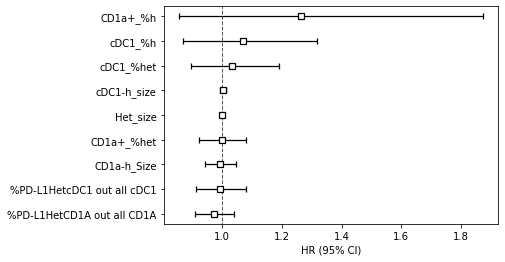

In [358]:
# Mutivariate
def Cox(df):
    df = df.drop(columns="Pt")
    c=cph.fit(df, duration_col="Days", event_col="ifRelapse")
    bx=c.plot(hazard_ratios=True)
    
if __name__ == '__main__':
    Cox(df5)

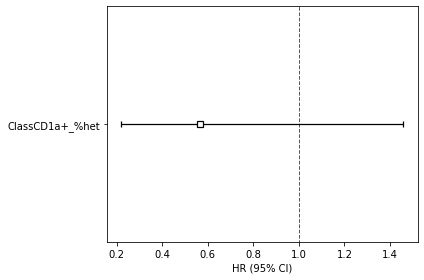

In [376]:
# For one of interest (univariate)
columnOfInterest = "ClassCD1a+_%het"
dataOfInterest = df4Class[["Days","ifRelapse",columnOfInterest]]
c=cph.fit(dataOfInterest, duration_col="Days", event_col="ifRelapse")
c.print_summary()
bx=c.plot(hazard_ratios=True)
bx.get_figure().tight_layout()
bx.get_figure().savefig('C:/Data/Cox/class%s.tiff'% columnOfInterest, format='tiff', dpi=600)

<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0
<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

KM curves
KM curves


<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0
<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

KM curves
KM curves


<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0
<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

KM curves


<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0
<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

KM curves
KM curves


<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0


KM curves
KM curves


<ipython-input-402-1debf9f2faaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1["Class%s"%df4.columns[i]]=1
<ipython-input-402-1debf9f2faaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2["Class%s"%df4.columns[i]]=0


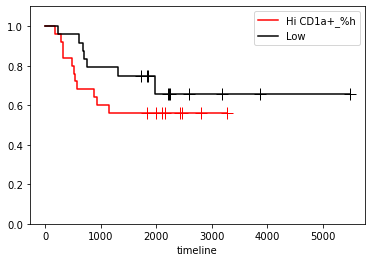

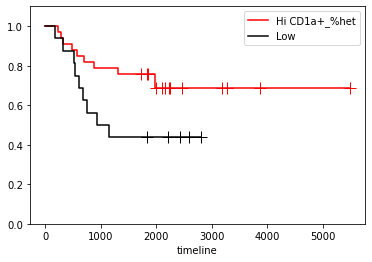

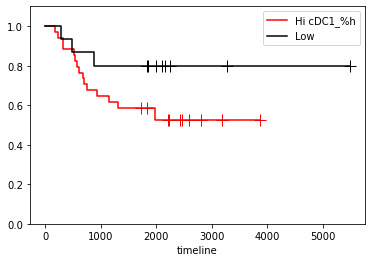

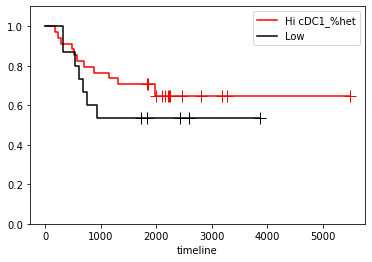

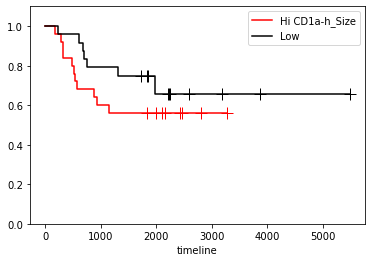

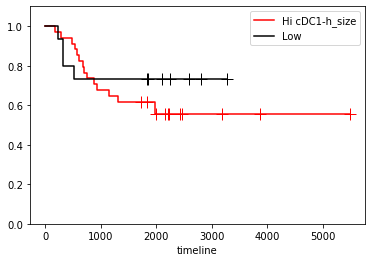

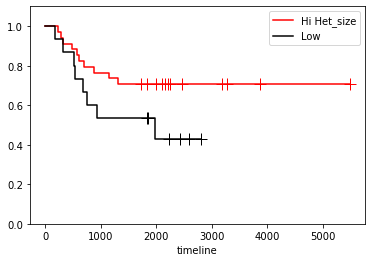

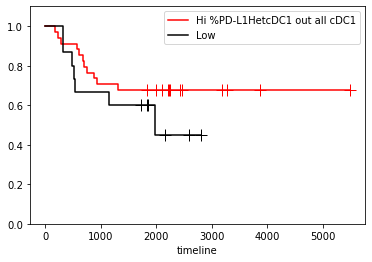

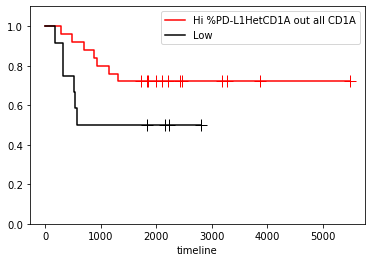

In [402]:
# Logrank #Categorical
cutOff=0.31
cut = df4.quantile([cutOff])

catgr, gPt, Logp, Vars  =[],[],[],[]
for i in np.arange(3, len(df4.columns)):
    g1=df4[(df4.iloc[:,i]>cut.iloc[0,i-1])]
    g2=df4[(df4.iloc[:,i]<=cut.iloc[0,i-1])]
    g1["Class%s"%df4.columns[i]]=1
    g2["Class%s"%df4.columns[i]]=0
    g = pd.concat([g1["Class%s"%df4.columns[i]], g2["Class%s"%df4.columns[i]]])
    gPt.append(pd.concat([g1,g2]))
    catgr.append(g)
    catgr_all=pd.DataFrame(catgr).transpose()
    complete_all=pd.concat(gPt,axis=1)
    df4Class = complete_all.loc[:,~complete_all.columns.duplicated()].drop(columns={"CD1a+_%h","CD1a+_%het","cDC1_%h","cDC1_%het","CD1a-h_Size",
                                                                                         "cDC1-h_size","Het_size","%PD-L1HetcDC1 out all cDC1","%PD-L1HetCD1A out all CD1A"})
    lr = logrank_test(g1.Days, g2.Days, g1.ifRelapse, g2.ifRelapse)
    Vars.append(df4.columns[i])
    Logp.append(lr.p_value)
    Log=pd.DataFrame(Log_p)
    
    plt.figure()
    print("KM curves")
    kmf1=kmf.fit(g1["Days"], g1["ifRelapse"], label="Hi %s"%df4.columns[i])
    ax=kmf.plot(color="red", ci_show=False,show_censors=True)
    
    kmf1=kmf.fit(g2["Days"], g2["ifRelapse"], label="Low")
    ax=kmf.plot(color="black", ci_show=False,show_censors=True)
    plt.ylim(0,1.1)
        
    ax.get_figure().savefig("C:/Users/DrHeh/Google Drive/programming/samples/Cox/KM%s.png"%df4.columns[i])
